# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
# デバッグモード
debug = True

res = AppRes()
excel = "ticks_20260122.xlsx"
# code = "285A"
# code = "7011"
# code = "7203"
code = "8306"
# code = "9984"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
THRESHOLD_PM_MIN = dict_setting["THRESHOLD_PM_MIN"]
THRESHOLD_DDR_MIN = dict_setting["THRESHOLD_DDR_MIN"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/22
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 50
PERIOD_MA_2 : 1000
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.03
PERIOD_RR : 30
TURBULENCE : 15
LOSSCUT_1 : -10
THRESHOLD_PM_MIN : 5.0
THRESHOLD_DDR_MIN : 0.5
N_MINUS_MAX : 120


In [3]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

if debug:
    output_dir = os.path.join("tmp", date_str)
else:
    output_dir = os.path.join("output", date_str)

os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買    約定単価  約定数量      損益 備考  \
0      1 2026-01-22 09:18:27.363862038  8306  買建  2872.0   100     NaN      
1      2 2026-01-22 09:19:54.690968990  8306  売埋  2865.0   100  -700.0      
2      3 2026-01-22 09:19:55.694525003  8306  売建  2865.0   100     NaN      
3      4 2026-01-22 09:21:50.954705954  8306  買埋  2871.5   100  -650.0      
4      5 2026-01-22 09:21:51.957582951  8306  買建  2871.5   100     NaN      
5      6 2026-01-22 09:23:10.083265066  8306  売埋  2867.0   100  -450.0      
6      7 2026-01-22 09:23:44.175713062  8306  売建  2866.0   100     NaN      
7      8 2026-01-22 09:30:41.599268913  8306  買埋  2868.5   100  -250.0      
8      9 2026-01-22 09:30:42.601821899  8306  買建  2868.0   100     NaN      
9     10 2026-01-22 09:32:24.887188911  8306  売埋  2866.5   100  -150.0      
10    11 2026-01-22 10:00:55.583792925  8306  売建  2853.5   100     NaN      
11    12 2026-01-22 10:22:03.637362957  8306  買埋  2848.0   100   550.0 

In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [5]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=9)],
        "累積損益": [0.0],
    }
)

end_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
        "累積損益": [pl.iloc[-1]],
    }
)

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row], ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-22 09:00:00.000000000       0.0
2026-01-22 09:18:27.363862038       0.0
2026-01-22 09:19:54.690968990    -700.0
2026-01-22 09:19:55.694525003    -700.0
2026-01-22 09:21:50.954705954   -1350.0
2026-01-22 09:21:51.957582951   -1350.0
2026-01-22 09:23:10.083265066   -1800.0
2026-01-22 09:23:44.175713062   -1800.0
2026-01-22 09:30:41.599268913   -2050.0
2026-01-22 09:30:42.601821899   -2050.0
2026-01-22 09:32:24.887188911   -2200.0
2026-01-22 10:00:55.583792925   -2200.0
2026-01-22 10:22:03.637362957   -1650.0
2026-01-22 10:22:12.637307882   -1650.0
2026-01-22 10:23:25.847315073   -1850.0
2026-01-22 10:25:43.331860065   -1850.0
2026-01-22 10:26:09.378165960   -2300.0
2026-01-22 10:26:10.382369995   -2300.0
2026-01-22 10:33:17.747553110   -2600.0
2026-01-22 10:33:18.738333941   -2600.0
2026-01-22 10:36:54.277991056   -2800.0
2026-01-22 10:38:56.639003992   -2800.0
2026-01-22 10:39:27.701340914   -2850.0
2026-01-22 10:45:52.628938913   -2850.0
2026-01-22 10:52:03.840729952   -29

output/2026/01/22/8306_trend_profit.png


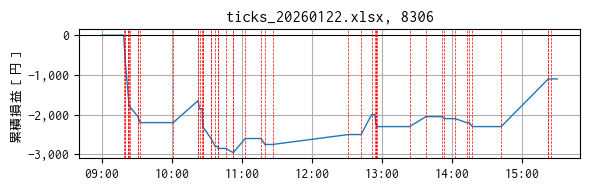

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [7]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts   price          ma1          ma2   mr  \
2026-01-22 09:03:00  1.769040e+09  2881.5  2881.500000  2881.500000  0.0   
2026-01-22 09:03:01  1.769040e+09  2881.5  2881.500000  2881.500000  0.0   
2026-01-22 09:03:02  1.769040e+09  2885.5  2882.833333  2882.833333  4.0   
2026-01-22 09:03:03  1.769040e+09  2885.5  2883.500000  2883.500000  4.0   
2026-01-22 09:03:04  1.769040e+09  2882.5  2883.300000  2883.300000  4.0   
...                           ...     ...          ...          ...  ...   
2026-01-22 15:24:45  1.769063e+09  2826.0  2827.420000  2827.547000  2.0   
2026-01-22 15:24:46  1.769063e+09  2826.0  2827.420000  2827.542500  2.0   
2026-01-22 15:24:47  1.769063e+09  2827.0  2827.420000  2827.539000  2.0   
2026-01-22 15:24:48  1.769063e+09  2827.0  2827.420000  2827.535500  2.0   
2026-01-22 15:24:49  1.769063e+09  2826.0  2827.410000  2827.530500  2.0   

                     disparity    slope1   rr  profit  profit_max  drawdown  \


In [8]:
df_tech["slope1"].describe()

count    19245.000000
mean         0.023047
std          0.028947
min          0.000000
25%          0.007333
50%          0.016333
75%          0.030000
max          0.800000
Name: slope1, dtype: float64

output/2026/01/22/8306_trend_technical.png


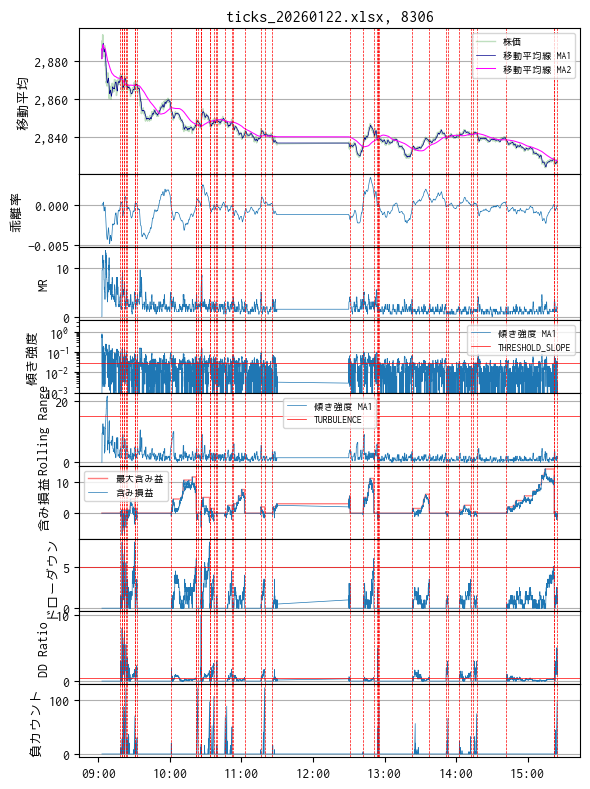

In [9]:
fig = plt.figure(figsize=(6, 8))
n = 9
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["disparity"], linewidth=0.5, label="MA乖離率")
ax[1].set_ylabel("乖離率")

ax[2].plot(df_tech["mr"], linewidth=0.5, label="移動範囲")
ax[2].set_ylabel("MR")

ax[3].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[3].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[3].set_yscale("log")
ax[3].set_ylabel("傾き強度")
ax[3].legend(fontsize=7)
_, y_high = ax[3].get_ylim()
ax[3].set_ylim(0.001, y_high)

ax[4].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[4].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[4].set_ylabel("Rolling Range")
ax[4].legend(fontsize=7)

ax[5].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[5].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[5].set_ylabel("含み損益")
ax[5].legend(fontsize=7)

ax[6].plot(df_tech["drawdown"], linewidth=0.5)
ax[6].axhline(y=THRESHOLD_PM_MIN, color="red", linewidth=0.5, label="THRESHOLD_PM_MIN")
ax[6].set_ylabel("ドローダウン")

ax[7].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[7].axhline(
    y=THRESHOLD_DDR_MIN, color="red", linewidth=0.5, label="THRESHOLD_DDR_MIN"
)
ax[7].set_ylabel("DD Ratio")

ax[8].plot(df_tech["n_minus"], linewidth=0.5)
ax[8].set_ylabel("負カウント")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/22/8306_hist_slope.png


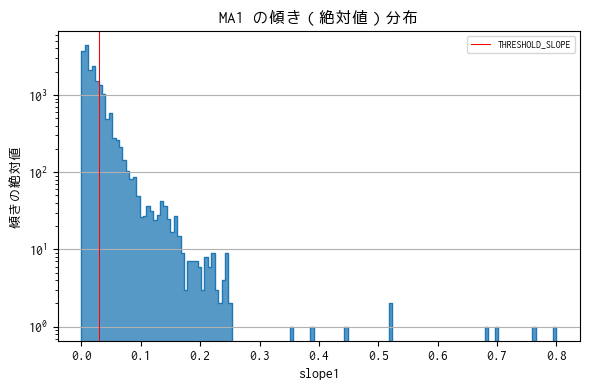

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/22/8306_hist_rr.png


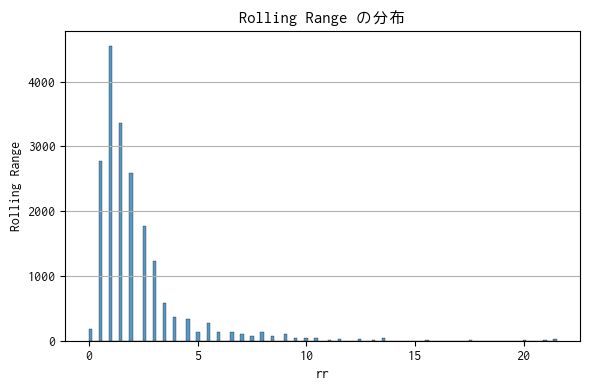

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [12]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  ロス2  利確1   建玉
2026-01-22 09:03:00    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-22 09:03:01    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-22 09:03:02    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-22 09:03:03    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-22 09:03:04    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...  ...
2026-01-22 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-22 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-22 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-22 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0
2026-01-22 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0 -1.0

[19245 rows x 8 columns]


output/2026/01/22/8306_trend_obs.png


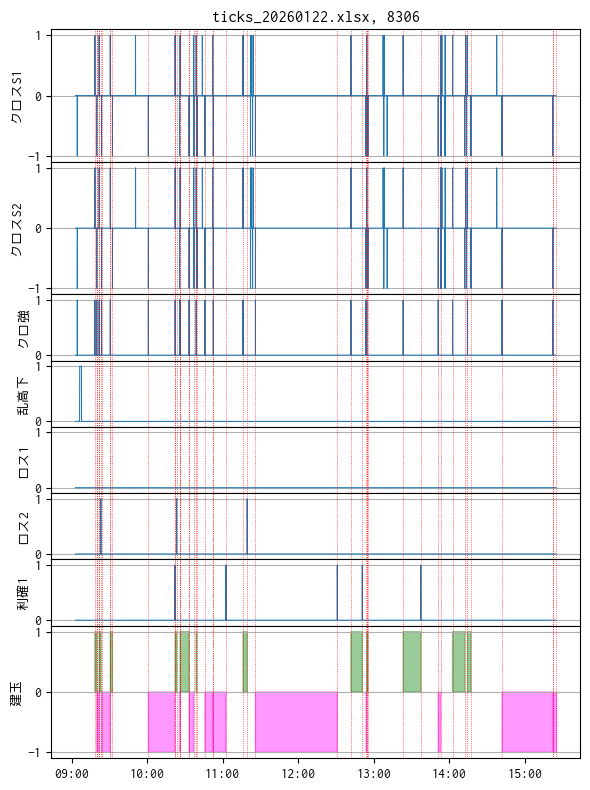

In [13]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()